In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import stats

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from imblearn.under_sampling import ClusterCentroids

#hiding warning messages
import warnings
warnings.filterwarnings("ignore")

#Reading in Summary MERGED CSV
data = pd.read_csv('Molecular_Properties_CSV')
data = data.astype(float, errors = 'ignore')
data.head()

,Activity Summary,PUBCHEM_CID,Ratio Efficacy (%),Ratio Potency (uM),MolecularFormula,MolecularWeight,CanonicalSMILES,IsomericSMILES,InChI,XLogP,ExactMass,TPSA
0,inactive,997.0,0.0000,0.00000,C9H8O3,164.160,C1=CC=C(C=C1)CC(=O)C(=O)O,C1=CC=C(C=C1)CC(=O)C(=O)O,InChI=1S/C9H8O3/c10-8(9(11)12)6-7-4-2-1-3-5-7/...,1.3,164.047,54.4
1,active antagonist,1807.0,-116.2980,54.94100,C4H6BrNO4,211.999,C1C(COCO1)([N+](=O)[O-])Br,C1C(COCO1)([N+](=O)[O-])Br,InChI=1S/C4H6BrNO4/c5-4(6(7)8)1-9-3-10-2-4/h1-3H2,0.3,210.948,64.3
2,active antagonist,2453.0,-141.2610,10.68220,C9H5Br2NO,302.953,C1=CC2=C(C(=C(C=C2Br)Br)O)N=C1,C1=CC2=C(C(=C(C=C2Br)Br)O)N=C1,InChI=1S/C9H5Br2NO/c10-6-4-7(11)9(13)8-5(6)2-1...,3.2,302.872,33.1
3,active antagonist,2662.0,-42.8802,21.31380,C17H14F3N3O2S,381.373,CC1=CC=C(C=C1)C2=CC(=NN2C3=CC=C(C=C3)S(=O)(=O)...,CC1=CC=C(C=C1)C2=CC(=NN2C3=CC=C(C=C3)S(=O)(=O)...,InChI=1S/C17H14F3N3O2S/c1-11-2-4-12(5-3-11)15-...,3.4,381.076,86.4
4,active antagonist,2722.0,-116.0110,5.56323,C9H5Cl2NO,214.045,C1=CC2=C(C(=C(C=C2Cl)Cl)O)N=C1,C1=CC2=C(C(=C(C=C2Cl)Cl)O)N=C1,InChI=1S/C9H5Cl2NO/c10-6-4-7(11)9(13)8-5(6)2-1...,3.5,212.975,33.1


In [2]:
#Making a 'target column', where inactives are 0 and actives are 1
activity_list = data['Activity Summary']
activity_list = activity_list.tolist()
target_list = []
i = 0

while (i < len(activity_list)):
    if (activity_list[i] == 'active antagonist'):
        target_list.append('1')
        i = i + 1
    elif (activity_list[i] == 'active agonist'):
        target_list.append('1')
        i = i + 1
    else:
        target_list.append('0')
        i = i + 1
        
#Making strings ints
target_list = [int(i) for i in target_list]

#adding target column to data
data['target'] = target_list

In [3]:
#Taking Dataframe of only Inactive values
###Drop all active agonists and active antagonists
df_inactive = data.drop(data.loc[data['Activity Summary'] == 'active agonist'].index)
df_inactive = df_inactive.drop(df_inactive.loc[df_inactive['Activity Summary'] == 'active antagonist'].index)

#Taking Dataframe of only Active values
##Dropping all inactive values
df_active = data.drop(data.loc[data['Activity Summary'] == 'inactive'].index)

In [4]:
#Printing number of active compounds
print("Number of active compounds in data: ")
print(len(df_active.index))

Number of active compounds in data: 
605


In [26]:
##ALSO drop pubchem_CID because thats not a feature
df_numerical = df_inactive.drop(['PUBCHEM_CID', 'Activity Summary', 'Ratio Potency (uM)', 'Ratio Efficacy (%)', 'MolecularFormula', 'CanonicalSMILES', 'IsomericSMILES', 'InChI', 'MolecularWeight', 'target'], axis = 1)
df_numerical.head()

,XLogP,ExactMass,TPSA
0,1.3,164.047,54.4
5,5.2,318.096,31.8
8,2.0,258.013,119.0
10,4.3,371.818,0.0
12,5.3,415.983,27.0


# PCA

In [7]:
#normalizing data 
df_numerical_pca = StandardScaler().fit_transform(df_numerical)

#computing covariance matrix
cov_mat = np.cov(df_numerical_pca.T)

#computing eigenvalues and eigenvectors using numpy
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

#Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

#Sort the eigehvalue, eigenvector) tuples from high to low
eig_pairs.sort(key = lambda x: x[0], reverse = True)

In [8]:
#Calculating "explained variance percentage"
##Quantifies how much info/variance can be attributed to each of the principal components
#only keeping a certain number of eigenvalues based on prespecified threshold

exp_var_percentage = 0.50 # Threshold of 97% explained variance

tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

num_vec_to_keep = 0

for index, percentage in enumerate(cum_var_exp):
    if percentage > exp_var_percentage:
        num_vec_to_keep = index + 1
        break

In [13]:
#Project our data on the vectors we want to keep
#Build a projection nmatrix (matrix we will multiply by to project our data onto the new vectors)

num_features = df_numerical.shape[1]
proj_mat = eig_pairs[0][1].reshape(num_features, 1)
for eig_vec_idx in range(1, num_vec_to_keep):
    proj_mat = np.hstack((proj_mat, eig_pairs[eig_vec_idx][1].reshape(num_features,1)))

# Project the data 
pca_data = df_numerical_pca.dot(proj_mat)

In [15]:
pca_data

array([[-0.39363519],
       [-0.39874511],
       [ 0.69212345],
       ...,
       [ 0.36624213],
       [ 0.2593213 ],
       [ 5.9450647 ]])

In [ ]:
#Undersampling: Cluster Centroids

In [52]:
#standardizing
clmns = ['ExactMass', 'TPSA', 'XLogP']
df_std = stats.zscore(df_numerical[clmns])

#Cluster the data
kmeans = KMeans(n_clusters=605, random_state=0).fit(df_std)
labels = kmeans.labels_

#Glue back to originaal data
df_numerical['clusters'] = labels

#Add the column into our list
clmns.extend(['clusters'])

#Lets analyze the clusters
#print(df_numerical[clmns].groupby(['clusters']).mean())

df_numerical = df_numerical.sort_values(by = ['clusters'], ascending = True, inplace = False)
df_numerical.head(30)

,XLogP,ExactMass,TPSA,clusters
5374,0.4,220.982,123.0,0
5110,0.3,196.023,124.0,0
6122,0.2,198.039,126.0,0
1221,0.3,233.055,121.0,0
2452,-0.2,237.961,126.0,0
5348,-0.1,210.002,125.0,0
3201,3.8,195.105,12.0,1
387,3.6,195.925,20.2,1
2398,3.7,195.925,20.2,1
668,3.4,188.120,17.1,1


Text(28.559609375000008, 0.5, 'TPSA')

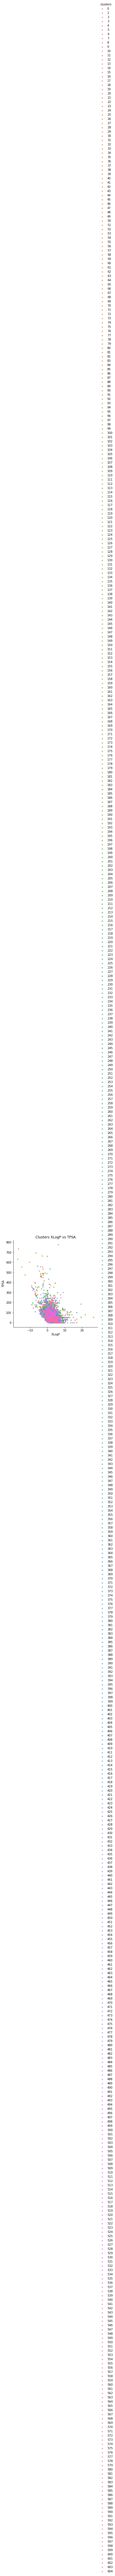

In [50]:
sns.lmplot('XLogP', 'TPSA', 
           data=df_numerical, 
           fit_reg=False, 
           hue="clusters",  
           scatter_kws={"marker": "D", 
                        "s": 10})
plt.title('Clusters XLogP vs TPSA')
plt.xlabel('XLogP')
plt.ylabel('TPSA')

In [51]:
print(df_numerical[clmns].groupby(['clusters']).mean())

            ExactMass        TPSA      XLogP
clusters                                    
0          349.063500  136.500000   2.000000
1          163.010071   26.932143   2.135714
2          867.101500  361.500000   1.500000
3          290.553125   36.462500   5.337500
4          220.418625   78.431250  -1.243750
5          551.275667  135.333333   4.833333
6          449.865750   37.925000  10.900000
7         1447.430000  531.000000  -2.600000
8          276.061826   54.052174   2.421739
9          457.986714  202.285714  -0.985714
10         137.096625   62.793750   0.156250
11         218.719269   16.788462   3.711538
12         387.967556   53.272222   4.005556
13         613.920000  356.000000  -8.933333
14         275.009273   78.609091   0.645455
15         692.116000  236.500000   2.675000
16         520.817800   78.940000   7.280000
17         105.212417   40.941667  -0.091667
18         712.579000   35.500000  16.900000
19         179.728000  126.333333  -4.333333
20        

In [ ]:
#also PCA and Undersampling

In [18]:
#df_numerical_no_targets = df_numerical.drop(columns = ['target'], axis = 1)
clmns2 = ['ExactMass', 'TPSA', 'XLogP']
X = np.array(data[clmns2])
y = np.array(data['target'])

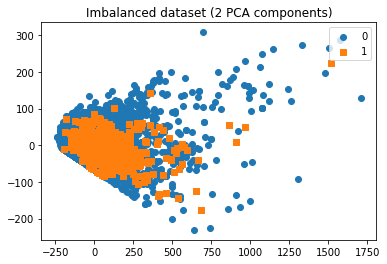

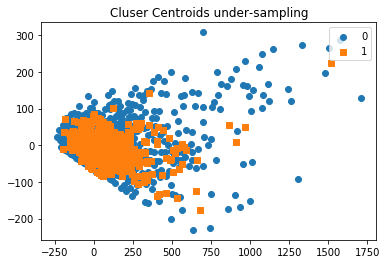

In [24]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

    
    
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(X)

plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')
    
    
    
    

cc = ClusterCentroids(ratio={0: 605})
X_cc, y_cc = cc.fit_sample(X, y)

plot_2d_space(X_cc, y_cc, 'Cluser Centroids under-sampling')

In [22]:
len(y_cc)

1210

In [33]:
from math import sqrt
def CCMUT(X,f):
    # 1. finding cluster centroid....
    cluster_centroid = np.sum(X,axis=0)/X.shape[0]
    # 2. finding Euclidean Distance from cluster centroid to samples
    euclidean = [None]*X.shape[0]
    for i in range(0,X.shape[0]):
        euclidean[i] = sqrt(sum((cluster_centroid-X[i])**2))
    # 3. tracking indices of samples in descending order of distance
    indices = list(reversed(sorted(range(len(euclidean)), 
    key = lambda j: euclidean[j])))
    # 4. removing the instances or under-sampling order-wise....
    X_f = np.delete(X, indices[:int(f/100*X.shape[0])], axis=0)
    # 5. returning the under-sampled Majority Sample Matrix
    return X_f

CCMUT(df_numerical, .5)

KeyError: 0